In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader
#from torch.autograd import grad
import cf_matrix
from sklearn.metrics import accuracy_score,confusion_matrix

# Load data

In [2]:
##### LOAD #########
# choose load file name 
train_path="/media/spandan/My Passport/D_drive_lockdown/Databases_post_lockdown/IIITH/traindata/MFCC_8KHz/Combined_pk_mfcc_Augmentation/"
test_path="/media/spandan/My Passport/D_drive_lockdown/Databases_post_lockdown/IIITH/testdata/MFCC_8KHz/Combined_pk_mfcc/"

f1 = train_path+'X_vad30_original_cms_IIITH.npy'
f2 = train_path+'y_vad30_original_cms_IIITH.npy'
f3 = train_path+'X_Aug-Cascade_2x_train_IIITH_cms.npy'
f4 = train_path+'y_Aug-Cascade_2x_train_IIITH_cms.npy'
f5 = test_path+'X_vad30_original_IIITH_test.npy'
f6 = test_path+'y_vad30_original_IIITH_test.npy'

X_train = np.load(f1,allow_pickle=True)
X_aug=np.load(f3,allow_pickle=True)
X_valid = np.load(f5,allow_pickle=True)
y_train = np.load(f2,allow_pickle=True)
y_aug=np.load(f4,allow_pickle=True)
y_valid = np.load(f6,allow_pickle=True)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_aug:{X_aug.shape}, y_aug:{y_aug.shape}') 
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')

X_train:(17015, 300, 20), y_train:(17015,)
X_aug:(30236, 300, 20), y_aug:(30236,)
X_valid:(4567, 300, 20), y_valid:(4567,)


In [3]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid,return_counts=True))

(array([0, 1, 2, 3, 4], dtype=object), array([3878, 3619, 3442, 3571, 2505]))
(array([0, 1, 2, 3, 4], dtype=object), array([6771, 6555, 5997, 6433, 4480]))
(array([0, 1, 2, 3, 4], dtype=object), array([ 833, 1077, 1007, 1134,  516]))


In [4]:
#not doing where separate source domains are needed as X_aug such as wgdrl
X_train=np.concatenate((X_train,X_aug))
del X_aug
y_train=np.concatenate((y_train,y_aug))
del y_aug

In [5]:
print(X_train.shape)
print(np.unique(y_train,return_counts=True))

(47251, 300, 20)
(array([0, 1, 2, 3, 4], dtype=object), array([10649, 10174,  9439, 10004,  6985]))


# CONFORMER


In [6]:
import torch
import torch.nn as nn
from conformer import Conformer

cuda = torch.cuda.is_available()  
device = torch.device('cuda' if cuda else 'cpu')

class Conformer_sd21(nn.Module):
    def __init__(self, input_dim = 20, num_classes=5):
        super(Conformer_sd21, self).__init__()
        self.conformer = Conformer(num_classes= 40, 
                      input_dim= input_dim, 
                      encoder_dim=64, 
                      num_encoder_layers=10)
        self.fc1 = nn.Linear(80, 512)
        self.fc2 = nn.Linear(512,512)
        self.drop = nn.Dropout(0.15)
        self.nonlinearity=nn.ReLU()
        self.bn = nn.BatchNorm1d(512)
        self.output = nn.Linear(512, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,inputs,input_lengths):
        conf_output,_ = self.conformer(inputs,input_lengths)
        #print(conf_output.shape)
        conf_mean_output = torch.mean(conf_output,axis=1)
        conf_std_output = torch.std(conf_output,axis=1)
        conf = torch.cat((conf_mean_output,conf_std_output),axis=1)
        #print(conf.shape)
        x = conf.reshape(conf.shape[0],-1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.nonlinearity(x)
        x = self.bn(x)
        x = self.drop(x)
#         x = self.fc2(x)
#         x = self.nonlinearity(x)
#         x = self.bn(x)
#         x = self.drop(x)
        predictions = self.output(x)
        final_pred = self.softmax(predictions)
        return conf_output, predictions, final_pred        

In [7]:
inputs = torch.rand(4, 300, 20).to(device)
input_lengths = torch.LongTensor([4]).to(device)
model = Conformer_sd21(20,5).to(device)
_,_,pred = model(inputs,input_lengths)
print(pred)

tensor([[0.3346, 0.1335, 0.1467, 0.1041, 0.2811],
        [0.2120, 0.2202, 0.2755, 0.1448, 0.1475],
        [0.2195, 0.2224, 0.1794, 0.1392, 0.2395],
        [0.1485, 0.1782, 0.1366, 0.3821, 0.1546]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


# Training

In [8]:
# def xv_data_manage(X_test):
#     aa=X_test.transpose((0,2,1))
#     print(X_test.shape, '-->', aa.shape)
#     return aa

In [9]:
# X_train=xv_data_manage(X_train)
# X_valid=xv_data_manage(X_valid)

In [10]:
def imbalance_class_weight(y,tot_class):
    classes=np.unique(y,return_counts=True)
    total_samples=np.sum(np.array(classes[1]))
    class_weights=np.empty(tot_class)
    for i,j in enumerate(classes[1]):
        print(i,'--->',j)
        class_weights[i]=total_samples/(tot_class*j)
    print(class_weights)
    return class_weights

In [11]:
class_weights_train=imbalance_class_weight(y_train,5)
class_weights_train2=class_weights_train/np.max(class_weights_train)
print(class_weights_train2)

0 ---> 10649
1 ---> 10174
2 ---> 9439
3 ---> 10004
4 ---> 6985
[0.88742605 0.92885787 1.00118657 0.94464214 1.3529277 ]
[0.65593013 0.68655396 0.74001483 0.69822071 1.        ]


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#deice=torch.device("cpu")
model = Conformer_sd21(20,5).to(device)
class_weights_train = torch.FloatTensor(class_weights_train2).to(device)
loss_fun = nn.CrossEntropyLoss(weight=class_weights_train)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)#, weight_decay=0.0000001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

In [13]:
trainloader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=300,drop_last=False)
testloader1 = torch.utils.data.DataLoader(list(zip(X_valid,y_valid)), shuffle=False, batch_size=32,drop_last=False)
#testloader2 = torch.utils.data.DataLoader(list(zip(X_test,y_test)), shuffle=True, batch_size=32,drop_last=False)
print(len(trainloader))
print(len(testloader1))
#print(len(testloader2))
#print(len(testloader3))

158
143


## Training cell

Epoch: 0, Batch: 0, Loss: 1.6179167032241821, Accuracy:18.333333333333332%
Epoch: 0, Batch: 50, Loss: 1.4424309730529785, Accuracy:43.0%
Epoch: 0, Batch: 100, Loss: 1.3742326498031616, Accuracy:51.0%
Epoch: 0, Batch: 150, Loss: 1.338608741760254, Accuracy:55.00000000000001%
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 1.0625486373901367, Accuracy:81.25%
#####TEST--in-domain:::::Epoch: 0, Batch: 50, Loss: 1.7850100994110107, Accuracy:6.25%
#####TEST--in-domain:::::Epoch: 0, Batch: 100, Loss: 1.2952650785446167, Accuracy:62.5%


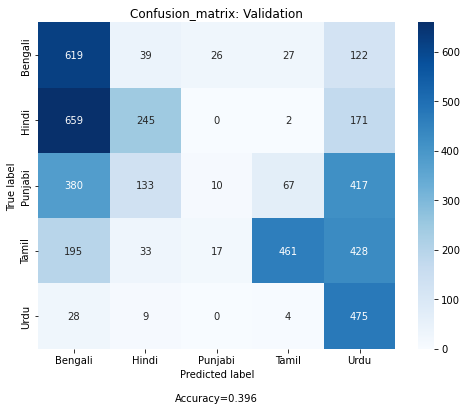

:::::Total vlidation loss 1.4876125254831114, Training accuracy 0.46236058496116483, Validation accuracy 0.39632143639150424 after 0 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 1, Batch: 0, Loss: 1.332502841949463, Accuracy:56.333333333333336%
Epoch: 1, Batch: 50, Loss: 1.32917058467865, Accuracy:52.666666666666664%
Epoch: 1, Batch: 100, Loss: 1.2285345792770386, Accuracy:67.0%
Epoch: 1, Batch: 150, Loss: 1.288297414779663, Accuracy:60.0%
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 0.9423234462738037, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 1, Batch: 50, Loss: 1.4753689765930176, Accuracy:43.75%
#####TEST--in-domain:::::Epoch: 1, Batch: 100, Loss: 1.0461779832839966, Accuracy:87.5%


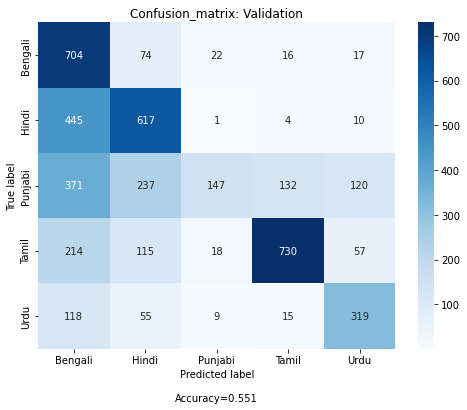

:::::Total vlidation loss 1.3410207591690384, Training accuracy 0.5941461556369177, Validation accuracy 0.5511276549156996 after 1 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 2, Batch: 0, Loss: 1.2766927480697632, Accuracy:62.66666666666667%
Epoch: 2, Batch: 50, Loss: 1.292493462562561, Accuracy:60.0%
Epoch: 2, Batch: 100, Loss: 1.2539671659469604, Accuracy:63.33333333333333%
Epoch: 2, Batch: 150, Loss: 1.2589703798294067, Accuracy:66.33333333333333%
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 1.2313013076782227, Accuracy:65.625%
#####TEST--in-domain:::::Epoch: 2, Batch: 50, Loss: 1.2738099098205566, Accuracy:62.5%
#####TEST--in-domain:::::Epoch: 2, Batch: 100, Loss: 1.0092333555221558, Accuracy:90.625%


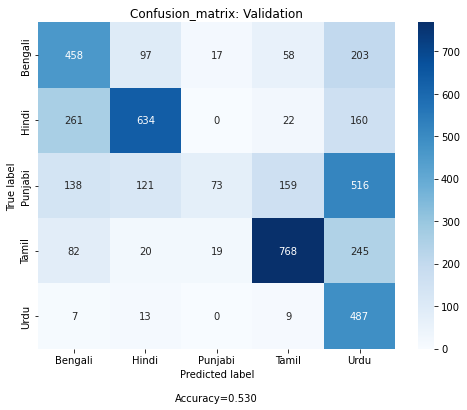

:::::Total vlidation loss 1.3634908611957843, Training accuracy 0.6407271803771348, Validation accuracy 0.5298883293190279 after 2 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 3, Batch: 0, Loss: 1.2791635990142822, Accuracy:62.0%
Epoch: 3, Batch: 50, Loss: 1.2368464469909668, Accuracy:65.33333333333333%
Epoch: 3, Batch: 100, Loss: 1.2364096641540527, Accuracy:65.33333333333333%
Epoch: 3, Batch: 150, Loss: 1.2007839679718018, Accuracy:69.33333333333334%
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 0.9414650797843933, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 3, Batch: 50, Loss: 1.2987033128738403, Accuracy:59.375%
#####TEST--in-domain:::::Epoch: 3, Batch: 100, Loss: 1.0028586387634277, Accuracy:87.5%


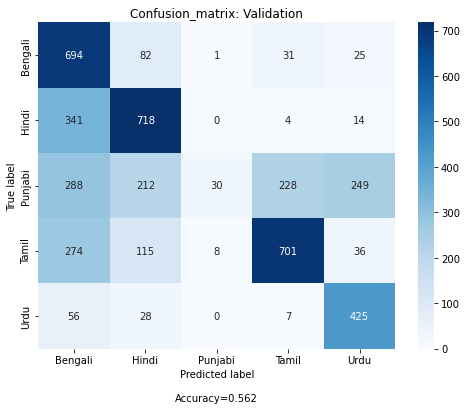

:::::Total vlidation loss 1.3361290476538918, Training accuracy 0.6641975831199339, Validation accuracy 0.5622947230129187 after 3 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 4, Batch: 0, Loss: 1.2058806419372559, Accuracy:68.66666666666667%
Epoch: 4, Batch: 50, Loss: 1.2241935729980469, Accuracy:67.0%
Epoch: 4, Batch: 100, Loss: 1.1861251592636108, Accuracy:70.66666666666667%
Epoch: 4, Batch: 150, Loss: 1.1846961975097656, Accuracy:71.66666666666667%
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 1.1566051244735718, Accuracy:75.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 50, Loss: 0.9048523902893066, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 4, Batch: 100, Loss: 0.943672239780426, Accuracy:96.875%


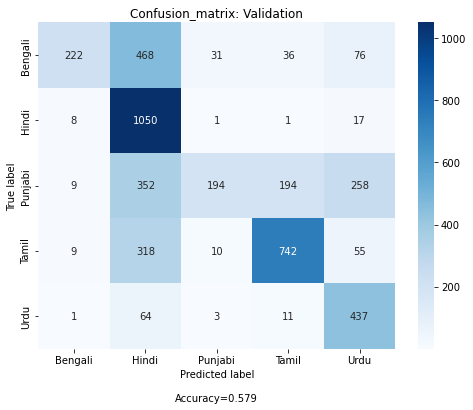

:::::Total vlidation loss 1.3180026516214118, Training accuracy 0.6821866203889865, Validation accuracy 0.5791548062185242 after 4 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 5, Batch: 0, Loss: 1.1855624914169312, Accuracy:71.33333333333334%
Epoch: 5, Batch: 50, Loss: 1.2183607816696167, Accuracy:67.0%
Epoch: 5, Batch: 100, Loss: 1.1666005849838257, Accuracy:73.66666666666667%
Epoch: 5, Batch: 150, Loss: 1.1849409341812134, Accuracy:71.0%
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 1.128020167350769, Accuracy:78.125%
#####TEST--in-domain:::::Epoch: 5, Batch: 50, Loss: 0.9353028535842896, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 5, Batch: 100, Loss: 0.9362096786499023, Accuracy:96.875%


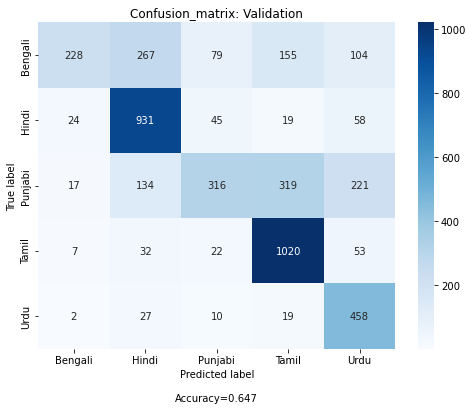

:::::Total vlidation loss 1.2537035917068695, Training accuracy 0.6992867875812152, Validation accuracy 0.6465951390409459 after 5 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 6, Batch: 0, Loss: 1.1515909433364868, Accuracy:74.66666666666667%
Epoch: 6, Batch: 50, Loss: 1.1639286279678345, Accuracy:72.66666666666667%
Epoch: 6, Batch: 100, Loss: 1.2175559997558594, Accuracy:66.33333333333333%
Epoch: 6, Batch: 150, Loss: 1.1629846096038818, Accuracy:73.66666666666667%
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 1.1336942911148071, Accuracy:75.0%
#####TEST--in-domain:::::Epoch: 6, Batch: 50, Loss: 0.9629444479942322, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 6, Batch: 100, Loss: 1.3076601028442383, Accuracy:56.25%


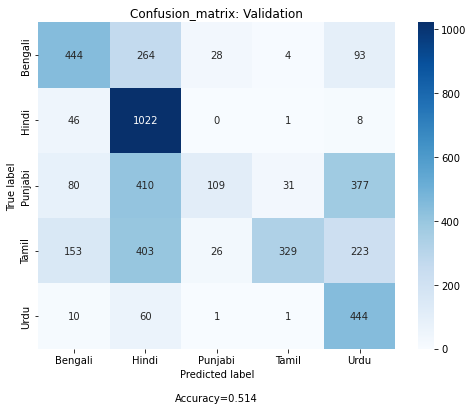

:::::Total vlidation loss 1.3817429167407376, Training accuracy 0.7093394848786269, Validation accuracy 0.514123056711189 after 6 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 7, Batch: 0, Loss: 1.1777886152267456, Accuracy:70.66666666666667%
Epoch: 7, Batch: 50, Loss: 1.1818369626998901, Accuracy:72.33333333333334%
Epoch: 7, Batch: 100, Loss: 1.1770468950271606, Accuracy:71.0%
Epoch: 7, Batch: 150, Loss: 1.1963043212890625, Accuracy:70.0%
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 0.96703040599823, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 7, Batch: 50, Loss: 1.154937982559204, Accuracy:71.875%
#####TEST--in-domain:::::Epoch: 7, Batch: 100, Loss: 1.0066100358963013, Accuracy:90.625%


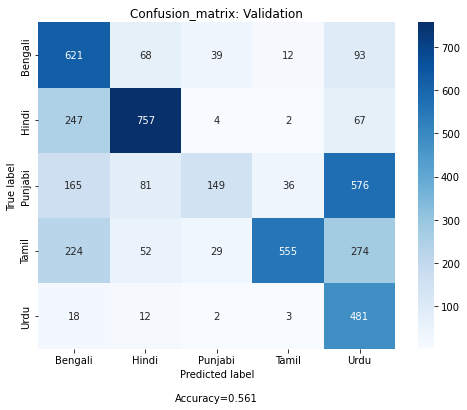

:::::Total vlidation loss 1.3342962390059359, Training accuracy 0.7242386404520539, Validation accuracy 0.5611999124151522 after 7 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 8, Batch: 0, Loss: 1.1148134469985962, Accuracy:78.33333333333333%
Epoch: 8, Batch: 50, Loss: 1.2089471817016602, Accuracy:69.0%
Epoch: 8, Batch: 100, Loss: 1.163256049156189, Accuracy:72.66666666666667%
Epoch: 8, Batch: 150, Loss: 1.1462393999099731, Accuracy:74.66666666666667%
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 0.9087290167808533, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 8, Batch: 50, Loss: 0.9868746399879456, Accuracy:90.625%
#####TEST--in-domain:::::Epoch: 8, Batch: 100, Loss: 0.9735586047172546, Accuracy:93.75%


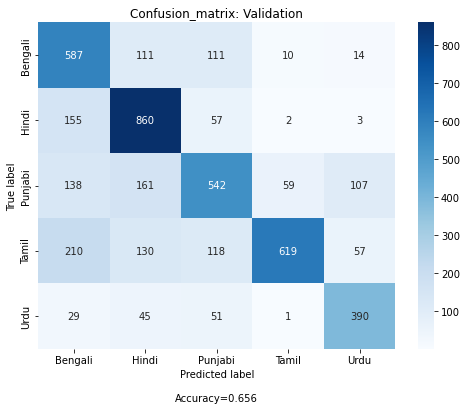

:::::Total vlidation loss 1.2456000643176632, Training accuracy 0.7295930244862543, Validation accuracy 0.6564484344208452 after 8 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 9, Batch: 0, Loss: 1.145081877708435, Accuracy:76.0%
Epoch: 9, Batch: 50, Loss: 1.131450891494751, Accuracy:76.66666666666667%
Epoch: 9, Batch: 100, Loss: 1.1546975374221802, Accuracy:74.0%
Epoch: 9, Batch: 150, Loss: 1.1838223934173584, Accuracy:71.33333333333334%
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 1.2144759893417358, Accuracy:68.75%
#####TEST--in-domain:::::Epoch: 9, Batch: 50, Loss: 1.0795515775680542, Accuracy:84.375%
#####TEST--in-domain:::::Epoch: 9, Batch: 100, Loss: 0.918491005897522, Accuracy:96.875%


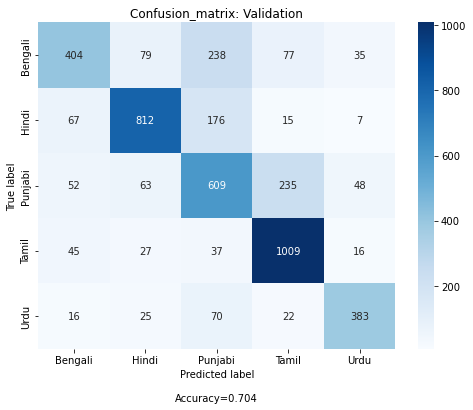

:::::Total vlidation loss 1.1978065083910536, Training accuracy 0.7411060083384479, Validation accuracy 0.7044011386030217 after 9 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 10, Batch: 0, Loss: 1.1421983242034912, Accuracy:76.33333333333333%
Epoch: 10, Batch: 50, Loss: 1.171006679534912, Accuracy:71.66666666666667%
Epoch: 10, Batch: 100, Loss: 1.103286623954773, Accuracy:78.66666666666666%
Epoch: 10, Batch: 150, Loss: 1.20475435256958, Accuracy:69.0%
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 1.0437222719192505, Accuracy:87.5%
#####TEST--in-domain:::::Epoch: 10, Batch: 50, Loss: 0.9352864027023315, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 10, Batch: 100, Loss: 0.9360771179199219, Accuracy:96.875%


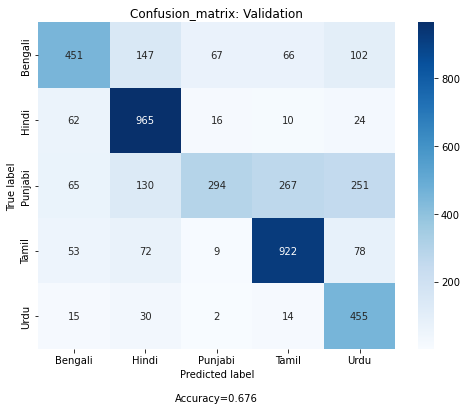

:::::Total vlidation loss 1.2242442911321467, Training accuracy 0.7507777613172208, Validation accuracy 0.6759360630610904 after 10 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 11, Batch: 0, Loss: 1.138880968093872, Accuracy:77.0%
Epoch: 11, Batch: 50, Loss: 1.1327757835388184, Accuracy:76.66666666666667%
Epoch: 11, Batch: 100, Loss: 1.132421851158142, Accuracy:76.66666666666667%
Epoch: 11, Batch: 150, Loss: 1.0970432758331299, Accuracy:80.66666666666666%
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 0.984687328338623, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 11, Batch: 50, Loss: 0.9499118328094482, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 11, Batch: 100, Loss: 0.9367072582244873, Accuracy:96.875%


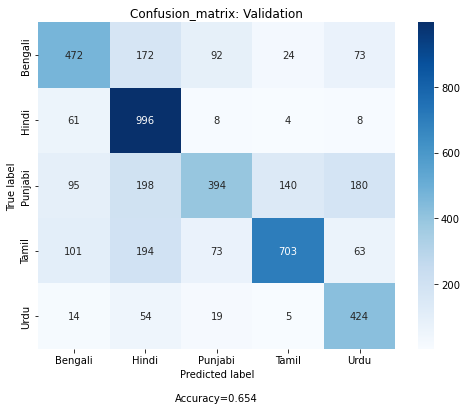

:::::Total vlidation loss 1.2443125902355967, Training accuracy 0.7552009481280819, Validation accuracy 0.6544777753448653 after 11 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 12, Batch: 0, Loss: 1.1442781686782837, Accuracy:75.33333333333333%
Epoch: 12, Batch: 50, Loss: 1.1270623207092285, Accuracy:76.0%
Epoch: 12, Batch: 100, Loss: 1.1544280052185059, Accuracy:74.33333333333333%
Epoch: 12, Batch: 150, Loss: 1.1698546409606934, Accuracy:72.33333333333334%
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 0.9474994540214539, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 12, Batch: 50, Loss: 0.9505626559257507, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 12, Batch: 100, Loss: 1.1255743503570557, Accuracy:75.0%


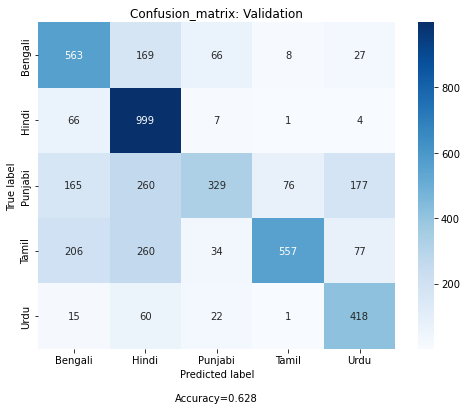

:::::Total vlidation loss 1.2698717730028646, Training accuracy 0.7591373727540158, Validation accuracy 0.6275454346398073 after 12 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 13, Batch: 0, Loss: 1.1643214225769043, Accuracy:72.66666666666667%
Epoch: 13, Batch: 50, Loss: 1.1157666444778442, Accuracy:78.33333333333333%
Epoch: 13, Batch: 100, Loss: 1.1200982332229614, Accuracy:77.66666666666666%
Epoch: 13, Batch: 150, Loss: 1.1205353736877441, Accuracy:77.66666666666666%
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 0.9385781288146973, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 13, Batch: 50, Loss: 1.042043685913086, Accuracy:84.375%
#####TEST--in-domain:::::Epoch: 13, Batch: 100, Loss: 0.9629952907562256, Accuracy:93.75%


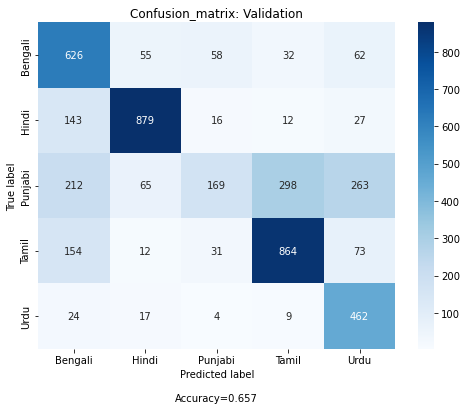

:::::Total vlidation loss 1.2438564967442225, Training accuracy 0.7660578612092865, Validation accuracy 0.6568863586599518 after 13 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 14, Batch: 0, Loss: 1.0972661972045898, Accuracy:80.33333333333333%
Epoch: 14, Batch: 50, Loss: 1.118940830230713, Accuracy:79.0%
Epoch: 14, Batch: 100, Loss: 1.0617471933364868, Accuracy:83.66666666666667%
Epoch: 14, Batch: 150, Loss: 1.152543306350708, Accuracy:73.66666666666667%
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 1.0918126106262207, Accuracy:81.25%
#####TEST--in-domain:::::Epoch: 14, Batch: 50, Loss: 0.966753363609314, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 14, Batch: 100, Loss: 0.9362708926200867, Accuracy:96.875%


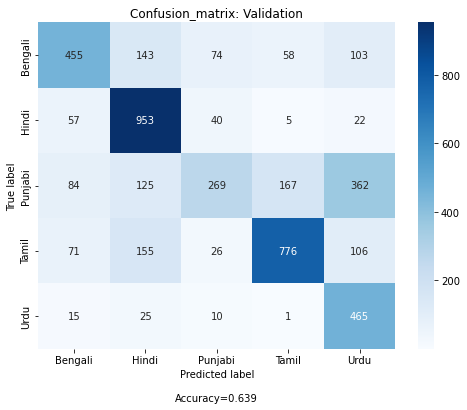

:::::Total vlidation loss 1.2582415496552741, Training accuracy 0.7817189054199911, Validation accuracy 0.6389314648565798 after 14 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 15, Batch: 0, Loss: 1.0765610933303833, Accuracy:82.0%
Epoch: 15, Batch: 50, Loss: 1.1409776210784912, Accuracy:76.0%
Epoch: 15, Batch: 100, Loss: 1.0738756656646729, Accuracy:83.33333333333334%
Epoch: 15, Batch: 150, Loss: 1.1168321371078491, Accuracy:78.66666666666666%
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 0.9645888805389404, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 15, Batch: 50, Loss: 0.9643234610557556, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 15, Batch: 100, Loss: 0.9403639435768127, Accuracy:96.875%


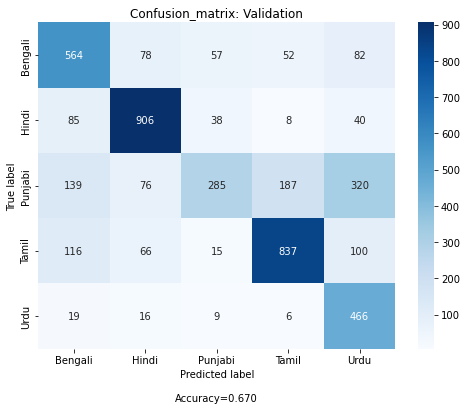

:::::Total vlidation loss 1.231673024334274, Training accuracy 0.786523036549491, Validation accuracy 0.6695861615940443 after 15 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 16, Batch: 0, Loss: 1.1017762422561646, Accuracy:80.0%
Epoch: 16, Batch: 50, Loss: 1.1470392942428589, Accuracy:75.0%
Epoch: 16, Batch: 100, Loss: 1.109076738357544, Accuracy:80.0%
Epoch: 16, Batch: 150, Loss: 1.1115704774856567, Accuracy:77.66666666666666%
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 0.9676539301872253, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 16, Batch: 50, Loss: 0.9181069731712341, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 16, Batch: 100, Loss: 0.9361150860786438, Accuracy:96.875%


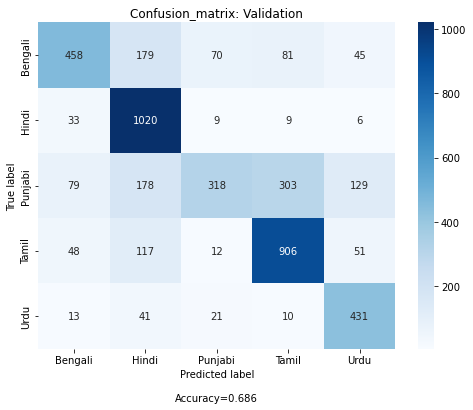

:::::Total vlidation loss 1.2149160562695323, Training accuracy 0.7880468138240461, Validation accuracy 0.6860083205605431 after 16 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 17, Batch: 0, Loss: 1.0728567838668823, Accuracy:84.0%
Epoch: 17, Batch: 50, Loss: 1.136723518371582, Accuracy:77.0%
Epoch: 17, Batch: 100, Loss: 1.0733915567398071, Accuracy:82.0%
Epoch: 17, Batch: 150, Loss: 1.1014151573181152, Accuracy:79.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 0.9553175568580627, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 17, Batch: 50, Loss: 0.9076107740402222, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 17, Batch: 100, Loss: 0.9370965361595154, Accuracy:96.875%


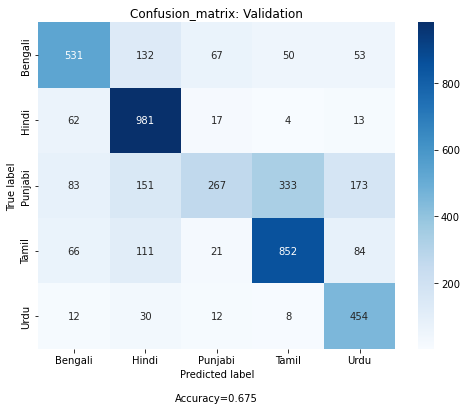

:::::Total vlidation loss 1.2247955894970393, Training accuracy 0.7894859368055702, Validation accuracy 0.6754981388219838 after 17 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch 00018: reducing learning rate of group 0 to 2.5000e-05.
Epoch: 18, Batch: 0, Loss: 1.1070467233657837, Accuracy:79.33333333333333%
Epoch: 18, Batch: 50, Loss: 1.0873894691467285, Accuracy:81.33333333333333%
Epoch: 18, Batch: 100, Loss: 1.1403155326843262, Accuracy:75.33333333333333%
Epoch: 18, Batch: 150, Loss: 1.1098943948745728, Accuracy:78.66666666666666%
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 1.0570042133331299, Accuracy:84.375%
#####TEST--in-domain:::::Epoch: 18, Batch: 50, Loss: 0.9048774838447571, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 18, Batch: 100, Loss: 0.9361231327056885, Accuracy:96.875%


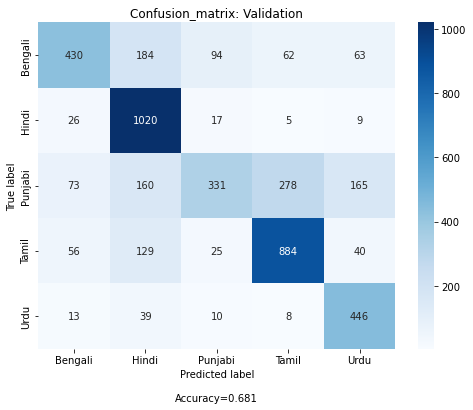

:::::Total vlidation loss 1.2194072324912866, Training accuracy 0.7975915853632727, Validation accuracy 0.68119115393037 after 18 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 19, Batch: 0, Loss: 1.0766050815582275, Accuracy:82.66666666666667%
Epoch: 19, Batch: 50, Loss: 1.090096116065979, Accuracy:81.66666666666667%
Epoch: 19, Batch: 100, Loss: 1.0942155122756958, Accuracy:80.0%
Epoch: 19, Batch: 150, Loss: 1.0535101890563965, Accuracy:85.33333333333334%
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 1.0661084651947021, Accuracy:81.25%
#####TEST--in-domain:::::Epoch: 19, Batch: 50, Loss: 0.9049525856971741, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 19, Batch: 100, Loss: 0.9363126158714294, Accuracy:96.875%


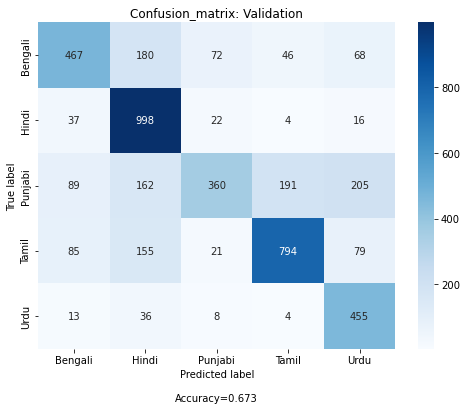

:::::Total vlidation loss 1.2243760849212433, Training accuracy 0.7988613997587353, Validation accuracy 0.6730895555068973 after 19 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 20, Batch: 0, Loss: 1.0621973276138306, Accuracy:83.33333333333334%
Epoch: 20, Batch: 50, Loss: 1.0988131761550903, Accuracy:80.66666666666666%
Epoch: 20, Batch: 100, Loss: 1.101831316947937, Accuracy:80.0%
Epoch: 20, Batch: 150, Loss: 1.0818355083465576, Accuracy:82.0%
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 0.9781898260116577, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 20, Batch: 50, Loss: 0.9188224077224731, Accuracy:96.875%
#####TEST--in-domain:::::Epoch: 20, Batch: 100, Loss: 0.9361004829406738, Accuracy:96.875%


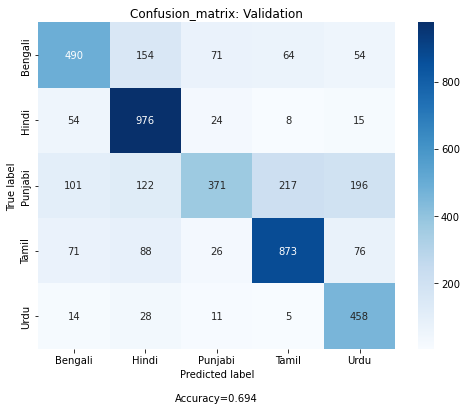

:::::Total vlidation loss 1.2081503659695179, Training accuracy 0.801210556390341, Validation accuracy 0.6936719947449091 after 20 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 21, Batch: 0, Loss: 1.0725975036621094, Accuracy:81.33333333333333%
Epoch: 21, Batch: 50, Loss: 1.137330174446106, Accuracy:76.66666666666667%
Epoch: 21, Batch: 100, Loss: 1.1080396175384521, Accuracy:79.0%
Epoch: 21, Batch: 150, Loss: 1.0800840854644775, Accuracy:81.33333333333333%
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 0.9819498658180237, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 21, Batch: 50, Loss: 0.9053904414176941, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 21, Batch: 100, Loss: 0.9367905259132385, Accuracy:96.875%


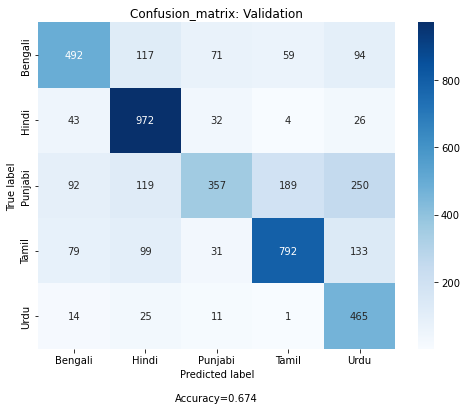

:::::Total vlidation loss 1.2260569388216191, Training accuracy 0.8027554972381536, Validation accuracy 0.6739654039851106 after 21 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch 00022: reducing learning rate of group 0 to 1.2500e-05.
Epoch: 22, Batch: 0, Loss: 1.1109532117843628, Accuracy:78.66666666666666%
Epoch: 22, Batch: 50, Loss: 1.1148629188537598, Accuracy:77.0%
Epoch: 22, Batch: 100, Loss: 1.1281582117080688, Accuracy:77.33333333333333%
Epoch: 22, Batch: 150, Loss: 1.0771251916885376, Accuracy:82.66666666666667%
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 0.9735783338546753, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 22, Batch: 50, Loss: 0.9048525094985962, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 22, Batch: 100, Loss: 0.9375651478767395, Accuracy:96.875%


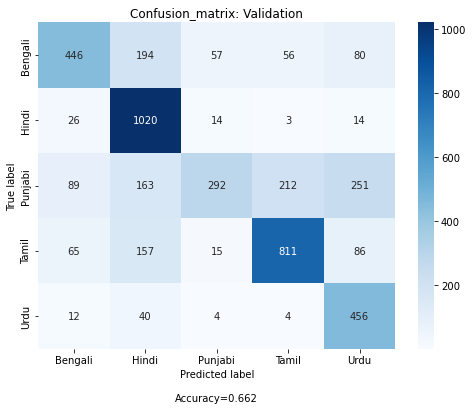

:::::Total vlidation loss 1.2382914278057071, Training accuracy 0.8079405726862924, Validation accuracy 0.6623604116487848 after 22 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 23, Batch: 0, Loss: 1.0741783380508423, Accuracy:83.0%
Epoch: 23, Batch: 50, Loss: 1.1117604970932007, Accuracy:78.33333333333333%
Epoch: 23, Batch: 100, Loss: 1.1127082109451294, Accuracy:79.33333333333333%
Epoch: 23, Batch: 150, Loss: 1.0986239910125732, Accuracy:79.33333333333333%
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 0.9702656269073486, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 23, Batch: 50, Loss: 0.9054118394851685, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 23, Batch: 100, Loss: 0.9361200928688049, Accuracy:96.875%


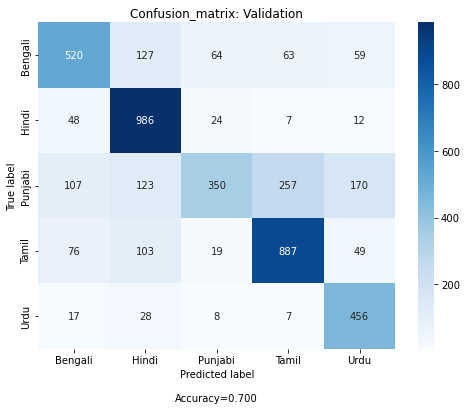

:::::Total vlidation loss 1.2001398176580043, Training accuracy 0.8070305390362109, Validation accuracy 0.7004598204510619 after 23 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 24, Batch: 0, Loss: 1.087783932685852, Accuracy:80.33333333333333%
Epoch: 24, Batch: 50, Loss: 1.1252737045288086, Accuracy:77.0%
Epoch: 24, Batch: 100, Loss: 1.1146388053894043, Accuracy:78.0%
Epoch: 24, Batch: 150, Loss: 1.0818058252334595, Accuracy:81.66666666666667%
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 0.9679858088493347, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 24, Batch: 50, Loss: 0.904975950717926, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 24, Batch: 100, Loss: 0.9361308813095093, Accuracy:96.875%


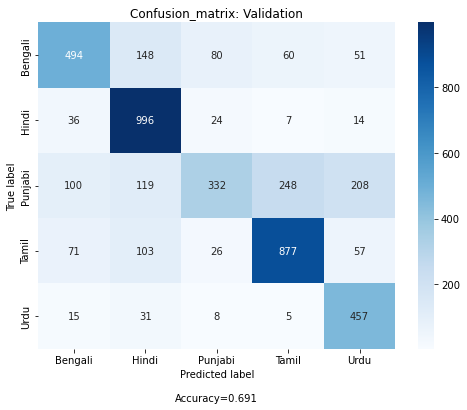

:::::Total vlidation loss 1.209830386655314, Training accuracy 0.8075384647943958, Validation accuracy 0.6910444493102693 after 24 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 25, Batch: 0, Loss: 1.0590364933013916, Accuracy:84.33333333333334%
Epoch: 25, Batch: 50, Loss: 1.088133692741394, Accuracy:81.0%
Epoch: 25, Batch: 100, Loss: 1.0689677000045776, Accuracy:83.33333333333334%
Epoch: 25, Batch: 150, Loss: 1.081007957458496, Accuracy:82.66666666666667%
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 0.9676535725593567, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 25, Batch: 50, Loss: 0.9313810467720032, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 25, Batch: 100, Loss: 0.9366397261619568, Accuracy:96.875%


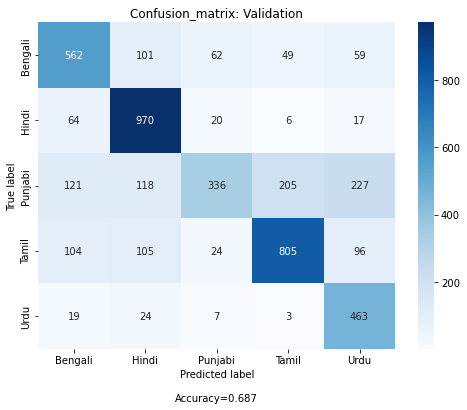

:::::Total vlidation loss 1.2147784845812337, Training accuracy 0.8089352606294047, Validation accuracy 0.686665206919203 after 25 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch 00026: reducing learning rate of group 0 to 6.2500e-06.
Epoch: 26, Batch: 0, Loss: 1.1145727634429932, Accuracy:77.33333333333333%
Epoch: 26, Batch: 50, Loss: 1.0748809576034546, Accuracy:83.33333333333334%
Epoch: 26, Batch: 100, Loss: 1.1172893047332764, Accuracy:79.66666666666666%
Epoch: 26, Batch: 150, Loss: 1.091352105140686, Accuracy:81.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 0, Loss: 0.9687305092811584, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 26, Batch: 50, Loss: 0.9081934690475464, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 26, Batch: 100, Loss: 0.9368540048599243, Accuracy:96.875%


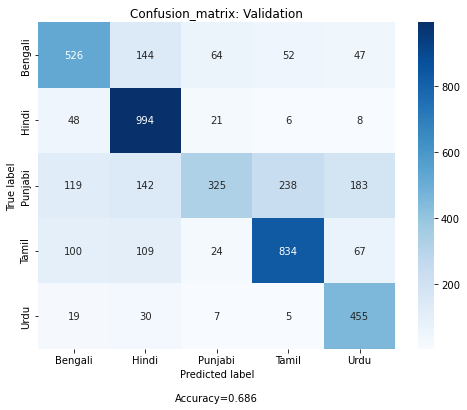

:::::Total vlidation loss 1.2126959649832931, Training accuracy 0.8110092908086601, Validation accuracy 0.6862272826800964 after 26 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 27, Batch: 0, Loss: 1.1130890846252441, Accuracy:78.33333333333333%
Epoch: 27, Batch: 50, Loss: 1.0778875350952148, Accuracy:81.33333333333333%
Epoch: 27, Batch: 100, Loss: 1.134662389755249, Accuracy:76.66666666666667%
Epoch: 27, Batch: 150, Loss: 1.0745835304260254, Accuracy:82.0%
#####TEST--in-domain:::::Epoch: 27, Batch: 0, Loss: 0.9674872159957886, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 27, Batch: 50, Loss: 0.907037079334259, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 27, Batch: 100, Loss: 0.9361407160758972, Accuracy:96.875%


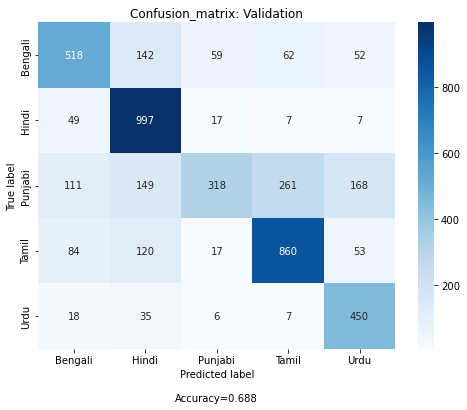

:::::Total vlidation loss 1.211868467447641, Training accuracy 0.8103743836109288, Validation accuracy 0.6881979417560762 after 27 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 28, Batch: 0, Loss: 1.1199188232421875, Accuracy:79.33333333333333%
Epoch: 28, Batch: 50, Loss: 1.1125662326812744, Accuracy:79.0%
Epoch: 28, Batch: 100, Loss: 1.1039948463439941, Accuracy:79.0%
Epoch: 28, Batch: 150, Loss: 1.0846858024597168, Accuracy:81.66666666666667%
#####TEST--in-domain:::::Epoch: 28, Batch: 0, Loss: 0.9679293036460876, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 28, Batch: 50, Loss: 0.9048519730567932, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 28, Batch: 100, Loss: 0.9361763000488281, Accuracy:96.875%


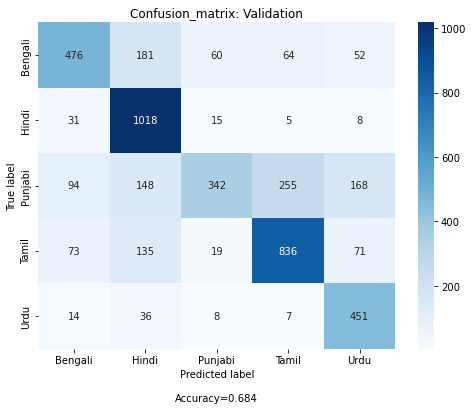

:::::Total vlidation loss 1.2166219791332324, Training accuracy 0.813273793147235, Validation accuracy 0.6838186993650098 after 28 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 29, Batch: 0, Loss: 1.0950613021850586, Accuracy:80.33333333333333%
Epoch: 29, Batch: 50, Loss: 1.0912889242172241, Accuracy:81.0%
Epoch: 29, Batch: 100, Loss: 1.080309510231018, Accuracy:81.66666666666667%
Epoch: 29, Batch: 150, Loss: 1.0688396692276, Accuracy:83.66666666666667%
#####TEST--in-domain:::::Epoch: 29, Batch: 0, Loss: 0.9668453931808472, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 29, Batch: 50, Loss: 0.9049116373062134, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 29, Batch: 100, Loss: 0.9361915588378906, Accuracy:96.875%


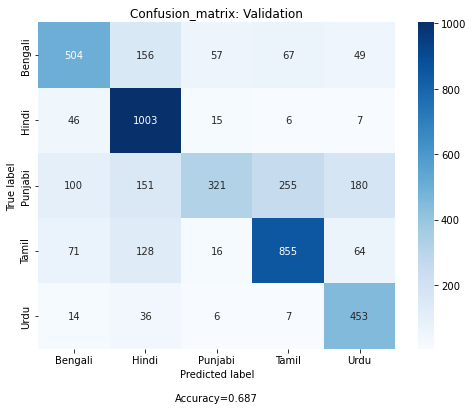

:::::Total vlidation loss 1.213447663750682, Training accuracy 0.8115807072866182, Validation accuracy 0.686665206919203 after 29 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch 00030: reducing learning rate of group 0 to 3.1250e-06.
Epoch: 30, Batch: 0, Loss: 1.0562636852264404, Accuracy:85.0%
Epoch: 30, Batch: 50, Loss: 1.0827633142471313, Accuracy:81.33333333333333%
Epoch: 30, Batch: 100, Loss: 1.0858891010284424, Accuracy:80.66666666666666%
Epoch: 30, Batch: 150, Loss: 1.0822499990463257, Accuracy:82.0%
#####TEST--in-domain:::::Epoch: 30, Batch: 0, Loss: 0.969329297542572, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 30, Batch: 50, Loss: 0.9049941301345825, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 30, Batch: 100, Loss: 0.9361317157745361, Accuracy:96.875%


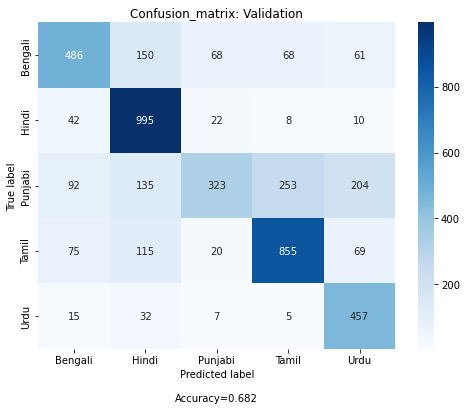

:::::Total vlidation loss 1.2155860303998827, Training accuracy 0.8143531353833782, Validation accuracy 0.6822859645281366 after 30 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 31, Batch: 0, Loss: 1.0517024993896484, Accuracy:85.66666666666667%
Epoch: 31, Batch: 50, Loss: 1.1083160638809204, Accuracy:79.0%
Epoch: 31, Batch: 100, Loss: 1.0830683708190918, Accuracy:81.66666666666667%
Epoch: 31, Batch: 150, Loss: 1.0577737092971802, Accuracy:84.33333333333334%
#####TEST--in-domain:::::Epoch: 31, Batch: 0, Loss: 0.969402551651001, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 31, Batch: 50, Loss: 0.9049152731895447, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 31, Batch: 100, Loss: 0.9361410140991211, Accuracy:96.875%


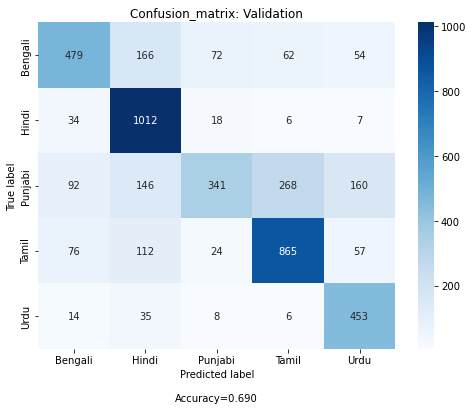

:::::Total vlidation loss 1.2104566789173579, Training accuracy 0.8145647711159553, Validation accuracy 0.6897306765929494 after 31 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 32, Batch: 0, Loss: 1.1118192672729492, Accuracy:78.66666666666666%
Epoch: 32, Batch: 50, Loss: 1.076428771018982, Accuracy:82.0%
Epoch: 32, Batch: 100, Loss: 1.0606250762939453, Accuracy:84.33333333333334%
Epoch: 32, Batch: 150, Loss: 1.0628420114517212, Accuracy:83.66666666666667%
#####TEST--in-domain:::::Epoch: 32, Batch: 0, Loss: 0.9693945050239563, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 32, Batch: 50, Loss: 0.9048920273780823, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 32, Batch: 100, Loss: 0.9361986517906189, Accuracy:96.875%


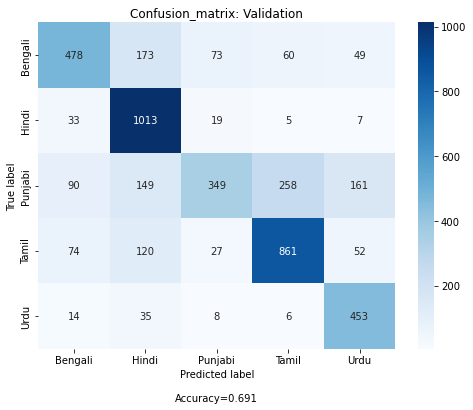

:::::Total vlidation loss 1.2092482022472195, Training accuracy 0.8132949567204927, Validation accuracy 0.6906065250711627 after 32 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 33, Batch: 0, Loss: 1.0790983438491821, Accuracy:82.33333333333334%
Epoch: 33, Batch: 50, Loss: 1.085078239440918, Accuracy:82.0%
Epoch: 33, Batch: 100, Loss: 1.0840367078781128, Accuracy:81.66666666666667%
Epoch: 33, Batch: 150, Loss: 1.084181785583496, Accuracy:82.33333333333334%
#####TEST--in-domain:::::Epoch: 33, Batch: 0, Loss: 0.9673956036567688, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 33, Batch: 50, Loss: 0.9048616290092468, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 33, Batch: 100, Loss: 0.9361494183540344, Accuracy:96.875%


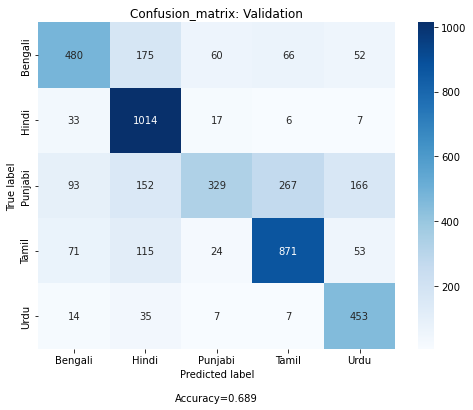

:::::Total vlidation loss 1.2093023436886448, Training accuracy 0.8132103024274618, Validation accuracy 0.6890737902342895 after 33 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch 00034: reducing learning rate of group 0 to 1.5625e-06.
Epoch: 34, Batch: 0, Loss: 1.0591318607330322, Accuracy:84.66666666666667%
Epoch: 34, Batch: 50, Loss: 1.1048474311828613, Accuracy:79.0%
Epoch: 34, Batch: 100, Loss: 1.0519332885742188, Accuracy:85.0%
Epoch: 34, Batch: 150, Loss: 1.1184208393096924, Accuracy:78.0%
#####TEST--in-domain:::::Epoch: 34, Batch: 0, Loss: 0.9670971035957336, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 34, Batch: 50, Loss: 0.9049251675605774, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 34, Batch: 100, Loss: 0.9361687898635864, Accuracy:96.875%


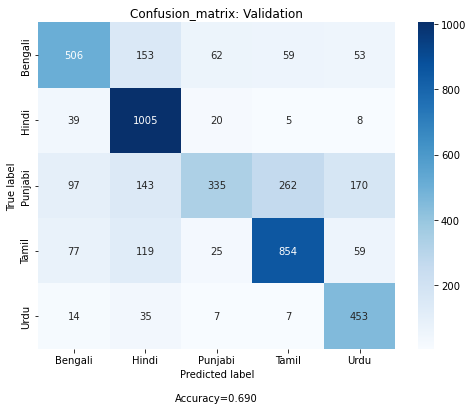

:::::Total vlidation loss 1.2092741977918398, Training accuracy 0.8140145182112548, Validation accuracy 0.6903875629516094 after 34 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 35, Batch: 0, Loss: 1.037830114364624, Accuracy:87.0%
Epoch: 35, Batch: 50, Loss: 1.064391016960144, Accuracy:83.66666666666667%
Epoch: 35, Batch: 100, Loss: 1.0666168928146362, Accuracy:83.33333333333334%
Epoch: 35, Batch: 150, Loss: 1.093775749206543, Accuracy:80.0%
#####TEST--in-domain:::::Epoch: 35, Batch: 0, Loss: 0.9678844213485718, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 35, Batch: 50, Loss: 0.904879093170166, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 35, Batch: 100, Loss: 0.9361317157745361, Accuracy:96.875%


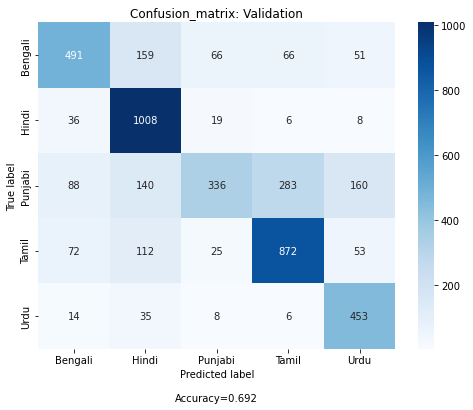

:::::Total vlidation loss 1.207705338101287, Training accuracy 0.8143319718101204, Validation accuracy 0.6919202977884826 after 35 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 36, Batch: 0, Loss: 1.0677179098129272, Accuracy:83.33333333333334%
Epoch: 36, Batch: 50, Loss: 1.0660187005996704, Accuracy:84.0%
Epoch: 36, Batch: 100, Loss: 1.0845328569412231, Accuracy:81.33333333333333%
Epoch: 36, Batch: 150, Loss: 1.0765129327774048, Accuracy:82.66666666666667%
#####TEST--in-domain:::::Epoch: 36, Batch: 0, Loss: 0.9676688313484192, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 36, Batch: 50, Loss: 0.9049955606460571, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 36, Batch: 100, Loss: 0.9361527562141418, Accuracy:96.875%


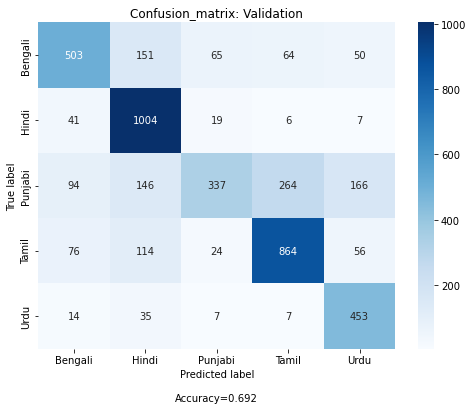

:::::Total vlidation loss 1.2090395626488266, Training accuracy 0.8142049903705741, Validation accuracy 0.6921392599080359 after 36 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 37, Batch: 0, Loss: 1.1015419960021973, Accuracy:80.0%
Epoch: 37, Batch: 50, Loss: 1.0870401859283447, Accuracy:80.66666666666666%
Epoch: 37, Batch: 100, Loss: 1.0523948669433594, Accuracy:85.33333333333334%
Epoch: 37, Batch: 150, Loss: 1.085037112236023, Accuracy:81.0%
#####TEST--in-domain:::::Epoch: 37, Batch: 0, Loss: 0.9691808223724365, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 37, Batch: 50, Loss: 0.9049057364463806, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 37, Batch: 100, Loss: 0.9362092614173889, Accuracy:96.875%


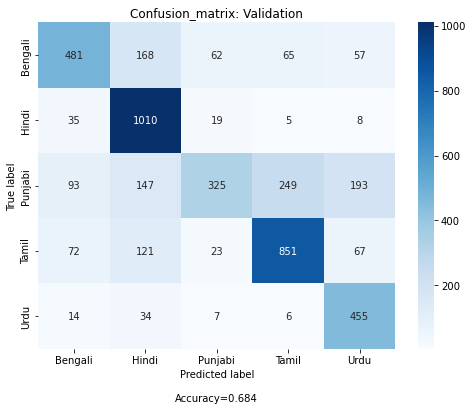

:::::Total vlidation loss 1.2153167224430537, Training accuracy 0.8155594590590676, Validation accuracy 0.6835997372454565 after 37 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch 00038: reducing learning rate of group 0 to 7.8125e-07.
Epoch: 38, Batch: 0, Loss: 1.0812174081802368, Accuracy:82.0%
Epoch: 38, Batch: 50, Loss: 1.076080560684204, Accuracy:82.33333333333334%
Epoch: 38, Batch: 100, Loss: 1.101710557937622, Accuracy:79.0%
Epoch: 38, Batch: 150, Loss: 1.0838205814361572, Accuracy:81.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 0, Loss: 0.9682727456092834, Accuracy:93.75%
#####TEST--in-domain:::::Epoch: 38, Batch: 50, Loss: 0.904900312423706, Accuracy:100.0%
#####TEST--in-domain:::::Epoch: 38, Batch: 100, Loss: 0.9361602663993835, Accuracy:96.875%


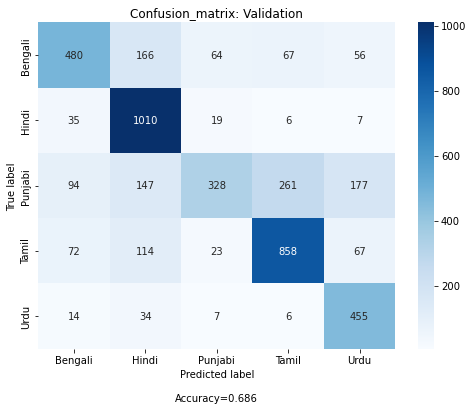

:::::Total vlidation loss 1.2128791229708211, Training accuracy 0.8137182281856469, Validation accuracy 0.6855703963214363 after 38 epochs
#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############
Epoch: 39, Batch: 0, Loss: 1.1025688648223877, Accuracy:79.0%
Epoch: 39, Batch: 50, Loss: 1.0948344469070435, Accuracy:81.66666666666667%


In [ ]:
dest_path="/home/spandan/EVALUATIONS/Cross_corpora/IIITH/Conformer_first/"
os.makedirs(dest_path,exist_ok=True)
Languages=["Bengali","Hindi","Punjabi","Tamil","Urdu"]

def train(dataloader_train,epoch):
    train_loss_list=[]
    train_acc_list=[]
    full_preds=[]
    full_gts=[]

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data 
        #print(features.shape)
        #print(labels.shape)
        #features=minmax(features)
        features, labels = features.to(device).float(),labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        _,_,pred_logits = model(features,torch.LongTensor([len(labels)]).to(device))
        loss = loss_fun(pred_logits,labels)
        #print(pred_logits.shape)
        #LOSS=[]
        #for ii in range(features.shape[1]):
        #    loss = loss_fun(features[:,ii,:],labels)
        #    LOSS.append(loss)
        #loss=torch.mean(torch.tensor(LOSS))
        #loss.requires_grad_(True)
        loss.backward()
        optimizer.step()
        predictions = np.argmax(pred_logits.detach().cpu().numpy(),axis=1)
        if i_batch%50==0:
            #print(final_pred)
            acc = accuracy_score(predictions,labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
        train_loss_list.append(loss.item())
        for pred in predictions:
            full_preds.append(pred)
        for lab in labels.detach().cpu().numpy():
            full_gts.append(lab)
    mean_acc = accuracy_score(full_gts,full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    return mean_acc
    print('Total training loss {} and training Accuracy {} after {} epochs'.format(mean_loss,mean_acc,epoch))
def validation(dataloader_val,epoch,train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list=[]
        full_preds=[]
        full_gts=[]
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            #features=minmax(features)
            features, labels = features.to(device).float(),labels.to(device).long()
            _,_,pred_logits = model(features,torch.LongTensor([len(labels)]).to(device))
            #print(features.shape)
            #print(labels.shape)
            loss = loss_fun(pred_logits,labels)
            val_loss_list.append(loss.item())
            predictions = np.argmax(pred_logits.detach().cpu().numpy(),axis=1)
            if i_batch%50==0:
                #print(final_pred)
                acc = accuracy_score(predictions,labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            for pred in predictions:
                full_preds.append(pred)
            for lab in labels.detach().cpu().numpy():
                full_gts.append(lab)
            
        mean_acc2 = accuracy_score(full_gts,full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm=confusion_matrix(full_gts,full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8,6), categories=Languages, cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(':::::Total vlidation loss {}, Training accuracy {}, Validation accuracy {} after {} epochs'.format(mean_loss2,train_accuracy, mean_acc2,epoch))
        print("#!#!#!#!!!##!##!!####!#####!###!#!##!##!##!#####!#############")
        model_save_path = os.path.join(dest_path, 'Conformer_XV_CD_mfcc_first_pooling_40_128_10_'+str(epoch)+'_'+str("{:.3f}".format(train_accuracy*100))+"_"+str("{:.3f}".format(mean_acc2*100)))
        state_dict = {'model': model.state_dict(),'optimizer': optimizer.state_dict(),'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return np.mean(np.array(val_loss_list))

if __name__ == '__main__':
     for epoch in range(40):
            mean_acc = train(trainloader,epoch)
            val_loss = validation(testloader1,epoch,mean_acc)
            scheduler.step(val_loss)
            #testing(testloader2,epoch,mean_acc)
            #testing(testloader3,epoch,mean_acc)

# clear cuda memory

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()